# House Price Regression - Exploratory Analysis

<b><i>This is part 1 of a 3 part series I am working on, to model the House Price Data in a professional manner</i></b>

I have done the project before, but as an amateur I made a mess out of the work I did. I wanted to revisit this work and use my updated skill set & professional experience to build something better. When I started out on my journey of becoming self taught Machine Learning Engineer, i thought the performance of your model is the only thing that matters, but now completing over an year in the industry, i have come to the realization that the journey to the final model is a long one and there are every step in itelf is a learning experince. I have started to enjoy the data cleaning and analysis part, as much as the model building part.

Kaggle has been a important part of my learning experince and I want to thank all the kagglers for it.

<b>The aim of the notebook is as follows</b>
<ul>
    <li>Identify Null value distribution in the dataset</li>
    <li>Find features/variables that will be useful for modeling</li>
    <li>Perform Unvariant and Multivariant analysis of selected features</li>
    <li>Build a baseline model, so future models can be comparable</li>
</ul>

I have tried to be as descriptive as possible, but if i have missed something please feel free to ask in comments.

<h3><b><i>“In God we trust. All others must bring data.” – W. Edwards Deming</i></b></h3>

<i>Ironically there is no proof of him saying that</i>

So lets get started, I hope you have as much fun reading this, as I had writing.
Please leave your thoughts in comments below.

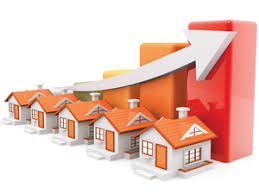

# Data Loading & Wrangling

<b>Or as I like to call it, <i>smell the data, before dinner</i></b>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot, linregress
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [ ]:
# Set the enviorment variables
train_file = os.path.join('..', 'input', 'house-prices-advanced-regression-techniques','train.csv')
train_file

In [ ]:
df = pd.read_csv(train_file)
print("Shape of Data is {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.sample(3)

<b>before we do any kind of analysis, we must check the kind of features we are working with & what percentage of those are null</b>

In [ ]:
# lambda function to calculate the null value distribution in dataframe
null_per = lambda x : ((x.isna()).sum()/len(x) * 100).sort_values(ascending=False)

In [ ]:
null_per(df).head(20)

<b>Note : </b>We will drop any feature which has more than 20% null values, as they wont be useful for modeling

In [ ]:
# Columns with more than 20% missing values
df[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].sample(10)

In [ ]:
print('What Kind of Data Types we are dealing with ?')
print("="*50)
df.dtypes.value_counts()

In [ ]:
cat_cols = df.drop('Id', axis=1).dtypes[df.dtypes == 'object'].index
num_cols = df.drop('Id', axis=1).dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index

In [ ]:
temp = df.loc[:,cat_cols]
uni_count = dict()
print("Unique Values Distribution in Categorical Values")
print("="*50)
for col in temp.columns:
    uni_count[col] = len(temp[col].unique())
pd.Series(uni_count).sort_values()

In [ ]:
print("Standard Deviation of Numerical Features")
print("="*50)
df.loc[:,num_cols].std().sort_values()

# Numerical Feature Analysis

<b>We can use Pearson's Correlation to find the useful features which might have strong impact on the dependent variable. As we have too many features, we can use a heatmap to visualize the correlation, between features.</b>

<b><i>Below is the Formula for calculating pearson correlation between two features.</i></b>

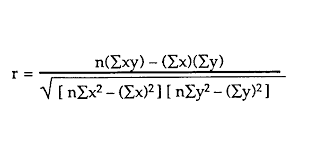

In [ ]:
corr_df = df.loc[:,num_cols].corr()

In [ ]:
fig,ax = plt.subplots(figsize=(12,10), dpi=100)
ax = sns.heatmap(corr_df, ax=ax, cmap='YlGnBu')

<b>We can start by looking at features highly correlated with Sale Price</b>

In [ ]:
sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(6,10),dpi=100)
ax =sns.barplot(x=sale_price_corr.values,y=sale_price_corr.keys(),)

<b>Let's select features with absolute correlation atleat above 0.6, as anything below that would not be useful for model development</b>

<b>We can zoom in on the selected features and get a better idea on correlation</b>

In [ ]:
corr_df_zoom = df[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF',
                   '1stFlrSF','FullBath','TotRmsAbvGrd']].corr()
fig,ax = plt.subplots(figsize=(4,3), dpi=100)
sns.heatmap(corr_df_zoom,ax=ax, cmap='Blues')

In [ ]:
sns.pairplot(df[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF',
                   '1stFlrSF','FullBath','TotRmsAbvGrd']])

# Univariant Analysis

<b>Also called <i>Personal Interview</i></b>

<b>Now That we have a small set of correlated features, we can start poking them individually, and try to find out there dirty secret</b>

<b>Probability Density Function : </b> It helps us understand where the data is concentrated, and how much variance are we dealing with, for example, we have a distribution which has mutiple peak point, it would better to bin them. On the other hand if any distribution has a long tail, we might want to set and value above a thereshold as maximum, or use a log function to correct that.


<b>Q-Q-Plot : </b>or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential. For example, if we run a statistical analysis that assumes our dependent variable is Normally distributed, we can use a Normal Q-Q plot to check that assumption. It’s just a visual check, not an air-tight proof, so it is somewhat subjective. But it allows us to see at-a-glance if our assumption is plausible, and if not, how the assumption is violated and what data points contribute to the violation

## Sale Price

In [ ]:
X = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Sale Price')
ax[0].grid()
probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Sale Price')
ax[1].grid()

<b>Ahh!! the distribution is just slightly skewed, lets see a small dose of "log therapy" helps</b>

In [ ]:
X = np.log(df['SalePrice'])
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm, color='green')
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].get_lines()[0].set_markerfacecolor('g')
ax[1].get_lines()[0].set_markeredgecolor('g')
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

<b>Vola!!!</b>

## Ground Living Area

In [ ]:
X = df['GrLivArea']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

<b>Same problem, Same solution</b>

In [ ]:
X = np.log(df['GrLivArea'])
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].get_lines()[0].set_markerfacecolor('g')
ax[1].get_lines()[0].set_markeredgecolor('g')
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

## Garage Area

In [ ]:
X = df['GarageArea']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

We might be tempted to apply log therapy to all the distributions we encounter, but remember, if it ain't broken, dont fix it.

<b>Feature Note : </b> As a substantial number of data points have zero garage area, we can use that build a new boolean feature, representing the presence of garage on the property

## Total Basement Surface Area

In [ ]:
X = df['TotalBsmtSF']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

<b>Our Q-Q Plot tells us that there is single outlier over 4000, which is causing major problems to the distribution. Lets throw it out and see what happens</b>

In [ ]:
X = df[df['TotalBsmtSF'] < 4000]['TotalBsmtSF']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

<b>Ma Ma Mia!!</b>

## 1st Floor Surface Area

In [ ]:
X = df[df['1stFlrSF'] < 3500]['1stFlrSF']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

<b>Log Therapy to the rescue</b>

In [ ]:
X = np.log(df[df['1stFlrSF'] < 3500]['1stFlrSF'])
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

## Total Rooms Above Ground

In [ ]:
X = df['TotRmsAbvGrd']
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
sns.distplot(X,ax=ax[0], fit=norm)
ax[0].title.set_text('Probability Mass Function')
ax[0].grid()

probplot(X, fit=norm, plot=ax[1])
ax[1].title.set_text('Q-Q Plot')
ax[1].grid()

<b>That is Ordinal Feature Hiding as Continues one.. But preet good looking shape it has..</b>

# Bivariant Analysis

<b>Or as know in the streets.. <i>Couples Therapy</i></b>

<b>Box Plot Distribution</b> : Helps visualize the distribution between continues and categorical features. It also gives a visual idea of trend in one feature as other varies. This can reveal useful information as to how the our dependent impacts the categorical feature, and might help us discover some new feature engineering ideas.

<b>Scatter Plot with Regression Fit</b> : Scatter plot is useful to visuallize the distribution between two continues features, but having a regression line fit through it, helps get an idea on the direction and strength of distribution.

## Overall Quality

In [ ]:
x = df['OverallQual']
y = df['SalePrice']
fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x=x, y=y, ax=ax)
ax.grid()

<b>That was kind of obvious, but i wonder what do they mean by Overall Quality, is it an aggreate of existing features</b>

## Ground Living Area

In [ ]:
x = np.log(np.array(df['GrLivArea']))
y = np.log(np.array(df['SalePrice']))
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=x, y=y, ax=ax)
lnrg = linregress((x,y))
y_lr = lnrg.slope*x + lnrg.intercept
sns.lineplot(x=x,y=y_lr,color='black')
ax.grid()

<b>For the features we have discovered log therapy as a useful tool, we will continue to use there log values in future analysis as well</b>

## Garage Cars

In [ ]:
x = df['GarageCars']
y = np.log(df['SalePrice'])
fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x=x, y=y, ax=ax)
ax.grid()

## Garage Area

In [ ]:
x = np.array(df['GarageArea'])
y = np.log(np.array(df['SalePrice']))
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=x, y=y, ax=ax)
lnrg = linregress((x,y))
y_lr = lnrg.slope*x + lnrg.intercept
sns.lineplot(x=x,y=y_lr,color='black')
ax.grid()

## Total Basement Surface Area

In [ ]:
x = np.array(df['TotalBsmtSF'])
y = np.array(df['SalePrice'])
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=x, y=y, ax=ax)
lnrg = linregress((x,y))
y_lr = lnrg.slope*x + lnrg.intercept
sns.lineplot(x=x,y=y_lr,color='black')
ax.grid()

## 1st Floor Surface Area

In [ ]:
x = np.array(df['1stFlrSF'])
y = np.log(np.array(df['SalePrice']))
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=x, y=y, ax=ax)
lnrg = linregress((x,y))
y_lr = lnrg.slope*x + lnrg.intercept
sns.lineplot(x=x,y=y_lr,color='black')
ax.grid()

## Full Bathrooms

In [ ]:
x = df['FullBath']
y = df['SalePrice']
fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x=x, y=y, ax=ax)
ax.grid()

## Total Rooms Above Ground

In [ ]:
x = df['TotRmsAbvGrd']
y = df['SalePrice']
fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x=x, y=y, ax=ax)
ax.grid()

## Ground Living Area -vs- Total Basement Surface Area

In [ ]:
x = np.array(df[df['TotalBsmtSF'] > 0]['GrLivArea'])
y = np.array(df[df['TotalBsmtSF'] > 0]['TotalBsmtSF'])
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=x, y=y, ax=ax)
lnrg = linregress((x,y))
y_lr = lnrg.slope*x + lnrg.intercept
sns.lineplot(x=x,y=y_lr,color='black')
ax.grid()

<b>If you look closely, this distribution tells you nice story. Most property with a basement have similar basement area as the ground floor living area, but some have smaller basements then the ground floor area, which makes perfect sense, bulding basements is expensive. But the intresting this is, there are few properties with basements bigger than the groundfloor. One might wonder, whats going on there!!!</b>

## Total Basement Surface Area -vs- 1st Floor Surface Area

In [ ]:
x = np.array(df['1stFlrSF'])
y = np.array(df['TotalBsmtSF'])
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=x, y=y, ax=ax)
lnrg = linregress((x,y))
y_lr = lnrg.slope*x + lnrg.intercept
sns.lineplot(x=x,y=y_lr,color='black')
ax.grid()

**Lets create new Binary Columns for Basement & Garage, so we can analyze there distribution as well.**

In [ ]:
df['has_basement'] = df['TotalBsmtSF'].apply(lambda x : 'Yes' if x > 0 else 'No')
df['has_garage'] = df['GarageArea'].apply(lambda x : 'Yes' if x > 0 else 'No')

In [ ]:
print('Properties Having Basement-Distribution : ')
print(df['has_basement'].value_counts()/len(df)*100)
print('='*50)
print('Properties Having Garage-Distribution : ')
print(df['has_garage'].value_counts()/len(df)*100)
print('='*50)

**The distribution of properties without basement is very small, there would not be of much use for us, but the properties without garage is significant, and can be important, let see if it is picked up in our next feature selection technique for categorical features.**

# Categorical Variable Analysis

<b>Feature Selection with categorical features can be a bit tricky, as there are many proven ways to do so, but no standard process. One of the proven technique is an overfitted Random Forest Regressor. We can use the feature importance statistic to select our features. There are many other ways you can try out, for example stepwise selection with Logistic Regression, but recently there has been some critisiom of these variance based techniques as they put too much importance on distribution of variable than the its predictive prowes.</b>

In [ ]:
df = df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1)

In [ ]:
cat_cols = df.dtypes[df.dtypes == 'object'].index
cat_cols

In [ ]:
X_dum = pd.get_dummies(df.loc[:,df.dtypes[df.dtypes == 'object'].index])
y = np.log(df['SalePrice'])

<b> We want to over fit a simple model on the dataset</b>

In [ ]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_dum, y)

In [ ]:
feat_import = pd.Series(dict(zip(X_dum.columns,clf.feature_importances_))).sort_values(ascending=False)
dummy_cols = list(X_dum.columns)
rows = dict()
for col in cat_cols:
    cols_to_sum = [w for w  in dummy_cols if re.search(col,w) != None]
    rows[col] = np.median(feat_import[cols_to_sum].sum())
rows = pd.Series(rows).sort_values(ascending=False)
print("Sum of Feature Importance of each feature, across it different categories")
print('='*80)
rows.head(10)

In [ ]:
feat_import = pd.Series(dict(zip(X_dum.columns,clf.feature_importances_))).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,12),dpi=100)
x = list(rows.values)
y = list(rows.index)
sns.barplot(x=x, y=y)

## Categorical Data, Univariant & MultiVariant Analysis

<b>We would like to make sure that the selected features are not some wirdos, for example, does one single category dominates, or is if it has too many categories with small distribution, so we can group them together.</b>

## Exterior Quality -vs- Sale Price

In [ ]:
x = df['ExterQual'].sort_values()
y = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(12,4),dpi=100)
sns.boxplot(x=x, y=y, ax=ax[1])
x = x.value_counts().sort_index()
sns.barplot(x=x.keys(),y=x.values,ax=ax[0])
ax[1].grid()

Although, Excellent Quality may have very high mean sale price, its distribution is too small to make an impact on the model.

## Basement Quality -vs- Sale Price

In [ ]:
x = df['BsmtQual'].sort_values()
y = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(12,4),dpi=100)
sns.boxplot(x=x, y=y, ax=ax[1])
x = x.value_counts().sort_index()
sns.barplot(x=x.keys(),y=x.values,ax=ax[0])
ax[1].grid()

## Neighborhood -vs- Sale Price

In [ ]:
x = df['Neighborhood'].sort_values()
y = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(16,4),dpi=100)
sns.boxplot(x=x, y=y, ax=ax[1])
x = x.value_counts().sort_index()
sns.barplot(x=x.keys(),y=x.values,ax=ax[0])
ax[1].grid()

<b>As there are too many categories for this feature, we might want bin them together based on there mean sale price, or geographicaly</b>

## Garage Type -vs- Sale Price

In [ ]:
x = df['GarageType'].sort_values()
y = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(16,4),dpi=100)
sns.boxplot(x=x, y=y, ax=ax[1])
x = x.value_counts().sort_index()
sns.barplot(x=x.keys(),y=x.values,ax=ax[0])
ax[1].grid()

## Kitchen Quality -vs- Sale Price

In [ ]:
x = df['KitchenQual'].sort_values()
y = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(16,4),dpi=100)
sns.boxplot(x=x, y=y, ax=ax[1])
x = x.value_counts().sort_index()
sns.barplot(x=x.keys(),y=x.values,ax=ax[0])
ax[1].grid()

## Zoning Classifcation -vs- Sale Price

In [ ]:
x = df['MSZoning'].sort_values()
y = df['SalePrice']
fig, ax = plt.subplots(ncols=2,figsize=(16,4),dpi=100)
sns.boxplot(x=x, y=y, ax=ax[1])
x = x.value_counts().sort_index()
sns.barplot(x=x.keys(),y=x.values,ax=ax[0])
ax[1].grid()

<b>As categories other than Residential are very small in number, perhaps we can group them together into a single "others" bin</b>

# BaseLine Model

<b>Before we can begain with feature engineering or model development, it is important to set our baseline, across which any future improvements will be measured. For example if we desgin a new feature and want to find its impact on our model, we can use our baseline model to compare the results.</b>

<b>For this exercise its important to split the dataset into training and testing sets, as we do not want a overfit model to be our baseline model.</b>

In [ ]:
num_cols_selected = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath',
                 'TotRmsAbvGrd']
cat_cols_selected = ['ExterQual', 'BsmtQual', 'Neighborhood', 'GarageType', 'KitchenQual','MSZoning']
target = 'SalePrice'

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.2)

<b>As any model we build, we will most certainly be performing feature scaling and one hot encoding, it is good idea to use the same basic transformations on our baseline model</b>

In [ ]:
train[cat_cols_selected] = train[cat_cols_selected].fillna('missing')
test[cat_cols_selected] = test[cat_cols_selected].fillna('missing')

one_hot = OneHotEncoder()
one_hot.fit(train[cat_cols_selected])
X_train_cat = one_hot.transform(train[cat_cols_selected]).toarray()
X_test_cat = one_hot.transform(test[cat_cols_selected]).toarray()

In [ ]:
ss = StandardScaler()
ss.fit(train[num_cols_selected])
X_train_num = ss.transform(train[num_cols_selected])
X_test_num = ss.transform(test[num_cols_selected])

In [ ]:
X_train = np.c_[X_train_cat, X_train_num]
X_test = np.c_[X_test_cat, X_test_num]

y_train, y_test = train[target], test[target]

In [ ]:
clf = RandomForestRegressor(n_estimators=100, bootstrap=True)
clf.fit(X_train, np.log(y_train))

In [ ]:
y_pred = clf.predict(X_test)
mse = mean_squared_error(np.log(y_test), y_pred)
rmse = np.sqrt(mse)
print('Root Mean Squared Error - Base Model - {}'.format(rmse))

<b>using the current model will place us in top 30% in Housing Regression Challenge, but we would need to reduce the score by third to have a descent shot at top 5%-10%.</b>

<b>Next we will be looking into Feature engineering and Pipeline building to streamline the transformations</b>

<h2>UpVote</h2>

If you enjoyed the notebook, this will motivate me to work harder on the next one.

<h2><i>“The great aim of education is not knowledge but action.” — Herbert Spencer</i></h2>